In [1]:
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.layers import BatchNormalization
from tensorflow.keras.models import Model
import random as rn
import cv2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow import keras
import albumentations as A

In [2]:
import tensorflow as tf
from tensorflow.keras import regularizers

In [3]:
! pip install kaggle
a=0

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download plant-pathology-2020-fgvc7

plant-pathology-2020-fgvc7.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
! unzip plant-pathology-2020-fgvc7.zip

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
dir_path = "images"

In [ ]:
list_of_train_data = []
for i in df.image_id:
    list_of_train_data.append(os.path.join(dir_path,i+".jpg"))

In [ ]:
train_image_labels = []
for i in df.values:
    train_image_labels.append(np.where(i[1:]==1)[0][0])

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Code for Confusion Matrix 

In [ ]:
def confusion_matrix_(x_train, y_train):
    b = np.empty((0,4),float)
    for i in tqdm(x_train):
        image_string = tf.io.read_file(i)
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)
        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        #resize the image
        image = tf.image.resize(image, [136,204])
        #print(image.shape)
        image = tf.expand_dims(image, axis=0)
        prediction = np.where(best_model.predict(image)[0] == best_model.predict(image)[0].max(), 1, 0)
        b = np.concatenate((b, np.array([np.array(prediction)])), axis=0)
        
    actual = np.array(tf.one_hot(tf.cast(y_train, tf.uint8), 4))
    actual_healthy = np.choose([0], actual.T)
    actual_multiple_diseases = np.choose([1], actual.T)
    actual_rust = np.choose([2], actual.T)
    actual_scab = np.choose([3], actual.T)

    predicted_healthy = np.choose([0], b.T)
    predicted_multiple_diseases = np.choose([1], b.T)
    predicted_rust = np.choose([2], b.T)
    predicted_scab = np.choose([3], b.T)
    
    plt.figure(figsize=(10,10))
    cm = confusion_matrix(actual_healthy, predicted_healthy,labels=[0,1])
    cmap=sns.light_palette("blue")
    plt.subplot(221)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".3f", xticklabels = ['Not Healthy','Healthy'], yticklabels = ['Not Healthy','Healthy'])


    cm = confusion_matrix(actual_multiple_diseases, predicted_multiple_diseases,labels=[0,1])
    cmap=sns.light_palette("blue")
    plt.subplot(222)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".3f", xticklabels = ['No Multiple Diseases','Multiple Diseases'], yticklabels = ['No Multiple Diseases','Multiple Diseases'])
    

    cm = confusion_matrix(actual_rust, predicted_rust,labels=[0,1])
    cmap=sns.light_palette("blue")
    plt.subplot(223)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".3f", xticklabels = ['Not Rusty','Rusty'], yticklabels = ['Not Rusty','Rusty'])

    cm = confusion_matrix(actual_scab, predicted_scab,labels=[0,1])
    cmap=sns.light_palette("blue")
    plt.subplot(224)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".3f", xticklabels = ['Not Scaby','Scaby'], yticklabels = ['Not Scaby','Scaby'])
    
    plt.show()


## Train Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(list_of_train_data, train_image_labels, test_size = 0.25, stratify = train_image_labels, random_state = 30)

In [ ]:
#height of 1365, and width of 2048.

In [ ]:
1368*0.1, 2048*0.1

(136.8, 204.8)

In [ ]:
#! pip install --upgrade albumentations

## Image Generator without Augmentation

In [ ]:
def tfdata_generator(images, labels, is_training, batch_size=32):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename, label):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        #resize the image
        image = tf.image.resize(image, [204, 136])
        #image = tf.cast(image, tf.float32) / 255.0
        #one hot coding for label
        

            
        y = tf.one_hot(tf.cast(label, tf.uint8), 4)
        return image, y
    
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    if is_training:
        dataset = dataset.shuffle(48000)  # depends on sample size

    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size,num_parallel_batches=6,  # cpu cores
        drop_remainder=True if is_training else False))
    
    #repeat the dataset indefinitely
    dataset = dataset.repeat()

    
    #prefetch the data into CPU/GPU
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
train_image_generator = tfdata_generator(x_train, y_train, True, batch_size=32)
test_image_generator = tfdata_generator(x_test, y_test, False, batch_size=32)

## Image Generator with Slighltly less Augmentation

In [ ]:
def tfdata_generator(images, labels, is_training, batch_size=32):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename, label):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        #resize the image
        image = tf.image.resize(image, [204, 136])
        #image = tf.cast(image, tf.float32) / 255.0
        #one hot coding for label
        
        if is_training:
            if np.random.uniform(0,1) > 0.6:
                image = tf.image.random_hue(image, 0.08)
                image = tf.image.random_saturation(image, 0.6, 1.6)
                image = tf.image.random_brightness(image, 0.05)
                image = tf.image.random_contrast(image, 0.7, 1.3)
        
            elif np.random.uniform(0,1) > 0.6:
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_flip_up_down(image)
            
        y = tf.one_hot(tf.cast(label, tf.uint8), 4)
        return image, y
    
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    if is_training:
        dataset = dataset.shuffle(48000)  # depends on sample size

    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size,num_parallel_batches=6,  # cpu cores
        drop_remainder=True if is_training else False))
    
    #repeat the dataset indefinitely
    dataset = dataset.repeat()

    
    #prefetch the data into CPU/GPU
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
train_image_generator = tfdata_generator(x_train, y_train, True, batch_size=32)
test_image_generator = tfdata_generator(x_test, y_test, False, batch_size=32)

## Image Generator with Slighltly more Augmentation

In [ ]:
def tfdata_generator_(images, labels, is_training, batch_size=32):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename, label):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)
        #print(image.shape)
        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        #print(image.shape)
        #resize the image
        
        #image = tf.cast(image, tf.float32) / 255.0
        #one hot coding for label
        
        if is_training:
          p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
          p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
          p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
          p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
          p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
          p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
            
          # Flips
          image = tf.image.random_flip_left_right(image)
          image = tf.image.random_flip_up_down(image)
          if p_spatial > .75:
            image = tf.image.transpose(image)
        
          # Rotates 
          if p_rotate > .75:
            image = tf.image.rot90(image, k=3) # rotate 270º
          elif p_rotate > .5:
            image = tf.image.rot90(image, k=2) # rotate 180º
          elif p_rotate > .25:
            image = tf.image.rot90(image, k=1) # rotate 90º
        
          # Pixel-level transforms
          if p_pixel_1 >= .4:
            image = tf.image.random_saturation(image, lower=.7, upper=1.3)
          if p_pixel_2 >= .4:
            image = tf.image.random_contrast(image, lower=.8, upper=1.2)
          if p_pixel_3 >= .4:
            image = tf.image.random_brightness(image, max_delta=.1)
        
          # Crops
          if p_crop > .7:
            if p_crop > .9:
              image = tf.image.central_crop(image, central_fraction=.7)
            elif p_crop > .8:
              image = tf.image.central_crop(image, central_fraction=.8)
            else:
              image = tf.image.central_crop(image, central_fraction=.9)
          elif p_crop > .4:
            crop_size = tf.random.uniform([], int(204*.8), 204, dtype=tf.int32)
            image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
        image = tf.image.resize(image, [136, 204])

        y = tf.one_hot(tf.cast(label, tf.uint8), 4)
        return image, y
    
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    if is_training:
        dataset = dataset.shuffle(64)  # depends on sample size

    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size,num_parallel_batches=6,  # cpu cores
        drop_remainder=True if is_training else False))
    
    #repeat the dataset indefinitely
    dataset = dataset.repeat()

    
    #prefetch the data into CPU/GPU
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
train_image_generator = tfdata_generator_(x_train, y_train, True, batch_size=32)
test_image_generator = tfdata_generator_(x_test, y_test, False, batch_size=32)

(None, None, 3)
(None, None, 3)
(None, None, 3)
(None, None, 3)


## Custom AUC Metric 

In [ ]:
def auc_score(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

In [ ]:
def auc_score(y_true, y_pred):
  try:
    roc_auc_score(y_true, y_pred)
  except ValueError:
    return 0.5
  return roc_auc_score(y_true, y_pred)
  

In [ ]:
#AUC score
def auc( y_true, y_pred ) :
    score = tf.py_function( auc_score,[y_true, y_pred],'float32',name='sklearnAUC' )
    return score

## Model Saving Callback

In [ ]:
class ModelSave(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.history = {'val_auc': []}
     
        
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_auc', -1) != -1:
            self.history['val_auc'].append(logs.get('val_auc'))

        if epoch>2: # Because the best model with probably appear after 4th epoch
            if self.history['val_auc'][-1] > max(self.history['val_auc'][:-1]): # if the validation acuuracy increased, save the model
                self.model.save('best_model'+str(epoch))

# Modelling Part

In [ ]:
!pip install -q efficientnet

     |████████████████████████████████| 50 kB 4.3 MB/s 


## EfficientNetB3 Model, with Heavy Augmentation

In [ ]:
from efficientnet.tfkeras import EfficientNetB3

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

In [ ]:
def get_model():

  base_model = EfficientNetB3(include_top=False, weights='noisy-student',input_shape=(204, 136, 3),pooling='avg')

  droupout1 = Dropout(0.2)(base_model.layers[-1].output)

  dense7 = Dense(units = 16,activation="relu", kernel_regularizer = regularizers.L2(l2=0.01))(droupout1)#(base_model.layers[-1].output)#, kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4
         
  out_layer = Dense(4,activation='softmax')(dense7)
  
  model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[auc],optimizer=tf.keras.optimizers.Adam())
  
  return  model



In [ ]:
model = get_model()

43941888/43933088 [==============================] - 1s 0us/step


In [ ]:
ms = ModelSave() 

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=20, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/20
42/42 [==============================] - 240s 5s/step - loss: 1.1648 - auc: 0.7296 - val_loss: 0.9943 - val_auc: 0.7917
Epoch 2/20
42/42 [==============================] - 174s 4s/step - loss: 0.8646 - auc: 0.8140 - val_loss: 1.0604 - val_auc: 0.7802
Epoch 3/20
42/42 [==============================] - 190s 5s/step - loss: 0.7533 - auc: 0.8362 - val_loss: 0.7773 - val_auc: 0.7871
Epoch 4/20
42/42 [==============================] - 185s 4s/step - loss: 0.6710 - auc: 0.7960 - val_loss: 1.6645 - val_auc: 0.7634
Epoch 5/20
42/42 [==============================] - 184s 4s/step - loss: 0.6006 - auc: 0.8173 - val_loss: 1.1665 - val_auc: 0.6697
Epoch 6/20
42/42 [==============================] - 262s 6s/step - loss: 0.6158 - auc: 0.8616 - val_loss: 0.4773 - val_auc: 0.8349
Epoch 7/20
42/42 [==============================] - 247s 6s/step - loss: 0.5776 - auc: 0.8264 - val_loss: 0.7385 - val_auc: 0.8429
Epoch 8/20
42/42 [==============================] - 96s 2s/step - loss: 0.5327 - au

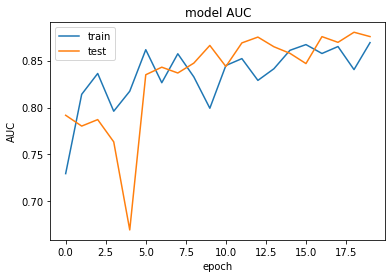

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

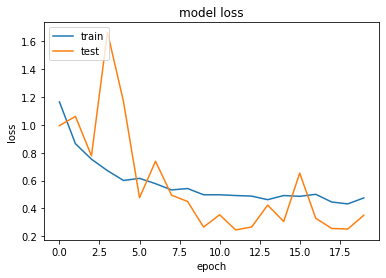

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model12', custom_objects={'auc':auc})

#### Running for 10 more epochs

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=10, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/10
42/42 [==============================] - 199s 5s/step - loss: 0.4535 - auc: 0.8505 - val_loss: 0.2969 - val_auc: 0.8700
Epoch 2/10
42/42 [==============================] - 178s 4s/step - loss: 0.4553 - auc: 0.8660 - val_loss: 0.3800 - val_auc: 0.8651
Epoch 3/10
42/42 [==============================] - 171s 4s/step - loss: 0.4663 - auc: 0.8824 - val_loss: 0.2454 - val_auc: 0.8673
Epoch 4/10
42/42 [==============================] - 162s 4s/step - loss: 0.3950 - auc: 0.8383 - val_loss: 0.2867 - val_auc: 0.8683
Epoch 5/10
42/42 [==============================] - 162s 4s/step - loss: 0.3961 - auc: 0.9010 - val_loss: 0.2768 - val_auc: 0.8653
Epoch 6/10
42/42 [==============================] - 245s 6s/step - loss: 0.4139 - auc: 0.8794 - val_loss: 0.2883 - val_auc: 0.8739
Epoch 7/10
42/42 [==============================] - 125s 3s/step - loss: 0.4073 - auc: 0.8658 - val_loss: 0.3274 - val_auc: 0.8587
Epoch 8/10
42/42 [==============================] - 169s 4s/step - loss: 0.4221 - a

In [ ]:
best_model = keras.models.load_model('best_model18_1', custom_objects={'auc':auc})

#### Confusion Matrix for Train Data

100%|██████████| 1365/1365 [04:32<00:00,  5.01it/s]


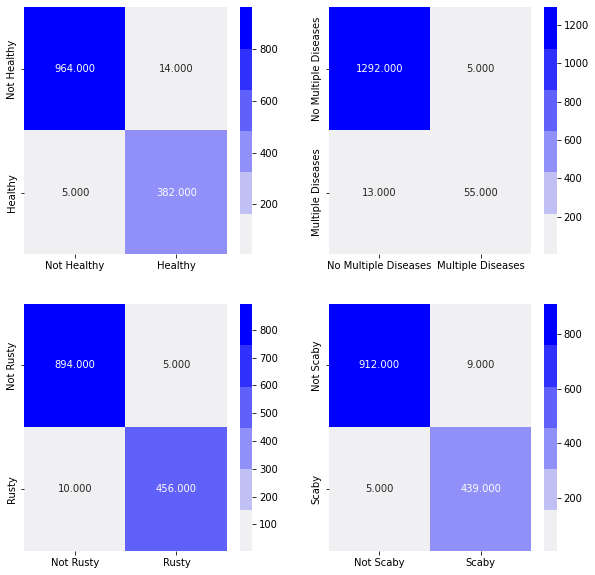

In [ ]:
confusion_matrix_(x_train, y_train)

#### Confusion Matrix for Test Data

100%|██████████| 456/456 [01:26<00:00,  5.26it/s]


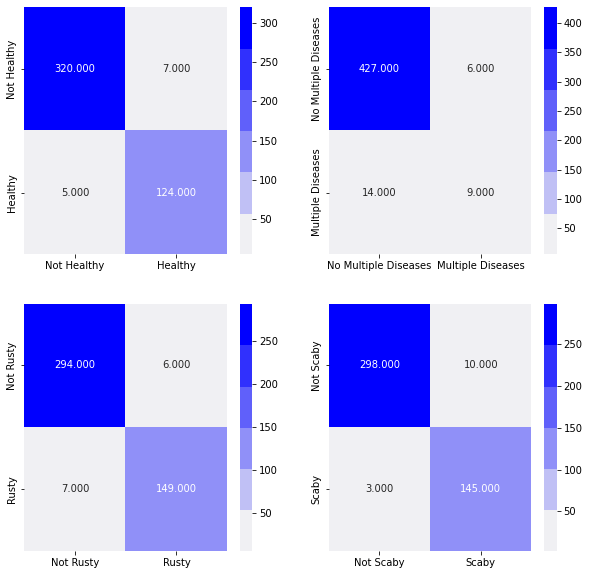

In [ ]:
confusion_matrix_(x_test, y_test)

# Kaggle Score for the above - 0.94573

## EfficientNetB5 Model, with Heavy Augmentation

In [ ]:
from efficientnet.tfkeras import EfficientNetB5

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers

In [ ]:
def get_model():

  base_model = EfficientNetB5(include_top=False, weights='noisy-student',input_shape=(204, 136, 3),pooling='avg')
  
  droupout1 = Dropout(0.2)(base_model.layers[-1].output)

  dense7 = Dense(units = 16,activation="relu", kernel_regularizer = regularizers.L2(l2=0.01))(droupout1)#(base_model.layers[-1].output)#, kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4
         
  out_layer = Dense(4,activation='softmax')(dense7)
  
  model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[auc],optimizer=tf.keras.optimizers.Adam())
  
  return  model



In [ ]:
model = get_model()

115269632/115255328 [==============================] - 2s 0us/step


In [ ]:
ms = ModelSave() 

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=40, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/40
42/42 [==============================] - 332s 7s/step - loss: 1.4409 - auc: 0.6434 - val_loss: 1.9081 - val_auc: 0.7261
Epoch 2/40
42/42 [==============================] - 235s 6s/step - loss: 0.9821 - auc: 0.7799 - val_loss: 1.6598 - val_auc: 0.7075
Epoch 3/40
42/42 [==============================] - 186s 4s/step - loss: 0.8488 - auc: 0.7615 - val_loss: 1.0860 - val_auc: 0.7472
Epoch 4/40
42/42 [==============================] - 309s 8s/step - loss: 0.7502 - auc: 0.8292 - val_loss: 0.8003 - val_auc: 0.8066
Epoch 5/40
42/42 [==============================] - 275s 7s/step - loss: 0.7192 - auc: 0.7865 - val_loss: 2.4503 - val_auc: 0.8088
Epoch 6/40
42/42 [==============================] - 310s 8s/step - loss: 0.6455 - auc: 0.8181 - val_loss: 0.6637 - val_auc: 0.8288
Epoch 7/40
42/42 [==============================] - 80s 2s/step - loss: 0.6560 - auc: 0.7923 - val_loss: 0.4831 - val_auc: 0.8251
Epoch 8/40
42/42 [==============================] - 162s 4s/step - loss: 0.6672 - au

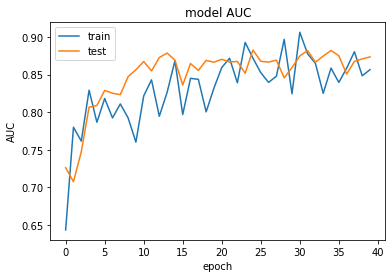

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

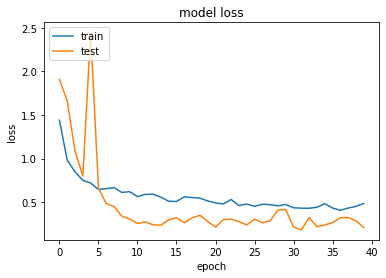

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model24', custom_objects={'auc':auc})

#### Confusion Matrix for Train Data

100%|██████████| 1365/1365 [05:36<00:00,  4.05it/s]


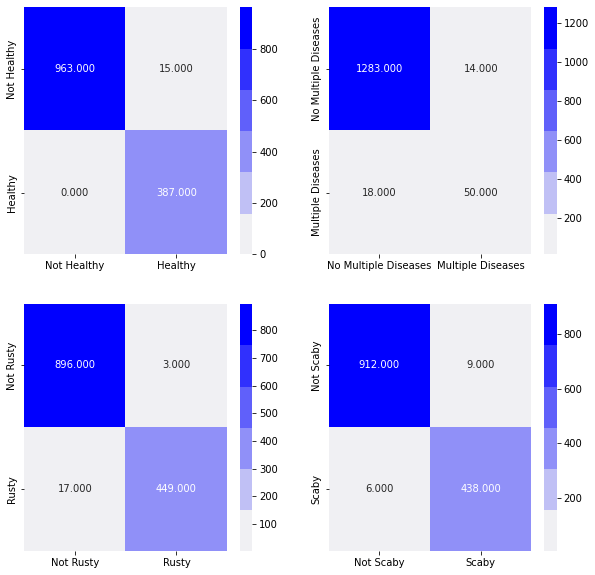

In [ ]:
confusion_matrix_(x_train, y_train)

#### Confusion Matrix for Test Data

100%|██████████| 456/456 [01:48<00:00,  4.18it/s]


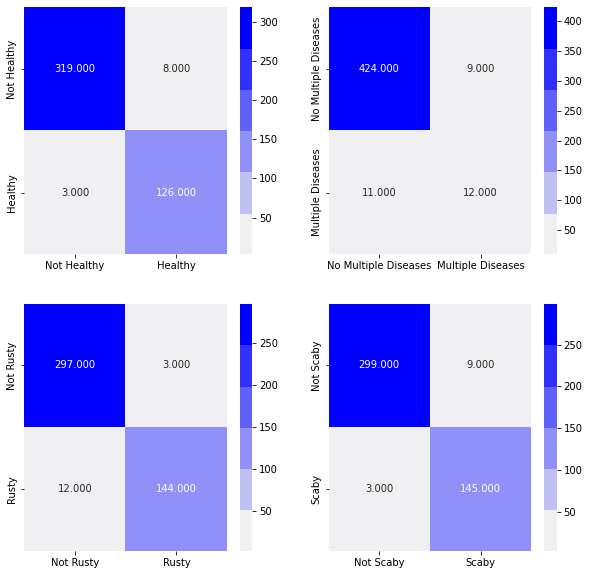

In [ ]:
confusion_matrix_(x_test, y_test)

# Kaggle Score for the above - 0.93979

## EfficientNetB4 Model, with Heavy Augmentation

In [ ]:
def get_model():

  base_model = EfficientNetB4(include_top=False, weights='noisy-student',input_shape=(204, 136, 3),pooling='avg')
  
  droupout1 = Dropout(0.2)(base_model.layers[-1].output)

  dense7 = Dense(units = 16,activation="relu", kernel_regularizer = regularizers.L2(l2=0.01))(droupout1)#(base_model.layers[-1].output)#, kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4
         
  out_layer = Dense(4,activation='softmax')(dense7)
  
  model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[auc],optimizer=tf.keras.optimizers.Adam())
  
  return  model



In [ ]:
model = get_model()
ms = ModelSave() 

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=40, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/40
42/42 [==============================] - 241s 5s/step - loss: 1.2562 - auc: 0.7068 - val_loss: 1.2530 - val_auc: 0.7694
Epoch 2/40
42/42 [==============================] - 187s 5s/step - loss: 0.9341 - auc: 0.7648 - val_loss: 0.6942 - val_auc: 0.8187
Epoch 3/40
42/42 [==============================] - 165s 4s/step - loss: 0.7987 - auc: 0.7965 - val_loss: 0.6357 - val_auc: 0.8113
Epoch 4/40
42/42 [==============================] - 165s 4s/step - loss: 0.6972 - auc: 0.8135 - val_loss: 1.1026 - val_auc: 0.7973
Epoch 5/40
42/42 [==============================] - 264s 6s/step - loss: 0.6882 - auc: 0.8161 - val_loss: 0.8005 - val_auc: 0.8297
Epoch 6/40
42/42 [==============================] - 139s 3s/step - loss: 0.6307 - auc: 0.8013 - val_loss: 1.1553 - val_auc: 0.8040
Epoch 7/40
42/42 [==============================] - 291s 7s/step - loss: 0.6112 - auc: 0.8296 - val_loss: 0.5577 - val_auc: 0.8382
Epoch 8/40
42/42 [==============================] - 106s 3s/step - loss: 0.5691 - a

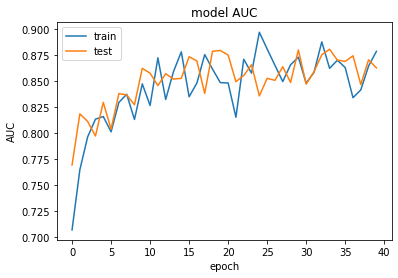

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

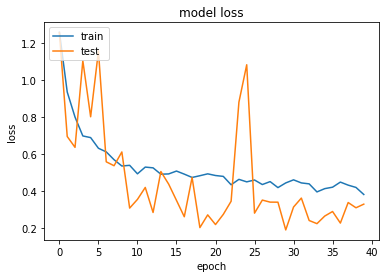

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Confusion Matrix for Train Data

100%|██████████| 1365/1365 [05:35<00:00,  4.07it/s]


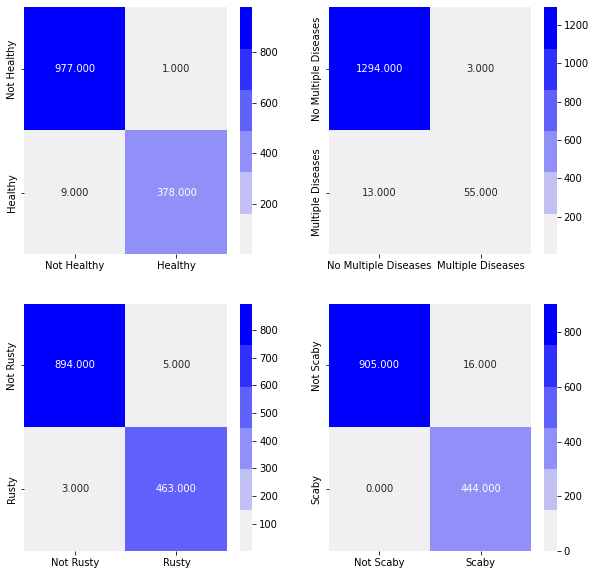

In [ ]:
confusion_matrix_(x_train, y_train)

#### Confusion Matrix for Test Data

100%|██████████| 456/456 [02:04<00:00,  3.66it/s]


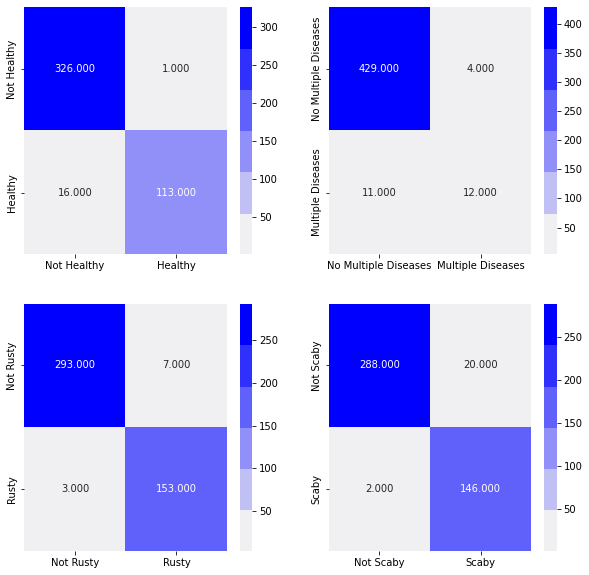

In [ ]:
confusion_matrix_(x_test, y_test)

In [ ]:
best_model = keras.models.load_model('best_model9', custom_objects={'auc':auc})

# Kaggle Score for the above 0.94074

#### Saving the Model to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'best_model_efficientnetb4_agumented'
path = F"/content/gdrive/My Drive/{model_save_name}" 
best_model.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/best_model_efficientnetb4_agumented/assets


# EfficientNetB4 Model, without Augumentations

In [ ]:
from efficientnet.tfkeras import EfficientNetB4

In [ ]:
def get_model():

  base_model = EfficientNetB4(include_top=False, weights='noisy-student',input_shape=(204, 136, 3),pooling='avg')
  #base_model.trainable = False

  #flattened = Flatten()(base_model.layers[-1].output)
    
  #droupout1 = Dropout(0)(flattened)
    
  #dense1 = Dense(units = 1024, activation="relu")(droupout1)
    
  #dense2 = Dense(units = 512, activation="relu")(dense1)
    
  #bn2 = BatchNormalization()(dense2)
    
  #dense3 = Dense(units = 256, activation="relu")(dense2)
    
  #dense4 = Dense(units = 128,activation="relu")(dense3)

  #dense5 = Dense(units = 128,activation="relu")(dense4)

  #dense6 = Dense(units = 64,activation="relu")(dense5)

  #dense7 = Dense(units = 16,activation="relu")(dense6)
  droupout1 = Dropout(0.2)(base_model.layers[-1].output)

  dense7 = Dense(units = 16,activation="relu", kernel_regularizer = regularizers.L2(l2=0.01))(droupout1)#(base_model.layers[-1].output)#, kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4
         
  out_layer = Dense(4,activation='softmax')(dense7)
  
  model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[auc],optimizer=tf.keras.optimizers.Adam())
  
  return  model



In [ ]:
model = get_model()

In [ ]:
ms = ModelSave() 

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=40, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/40
42/42 [==============================] - 104s 2s/step - loss: 1.1318 - auc: 0.7358 - val_loss: 0.9839 - val_auc: 0.7871
Epoch 2/40
42/42 [==============================] - 61s 1s/step - loss: 0.6069 - auc: 0.8788 - val_loss: 1.3729 - val_auc: 0.7892
Epoch 3/40
42/42 [==============================] - 61s 1s/step - loss: 0.3762 - auc: 0.8518 - val_loss: 3.6270 - val_auc: 0.7706
Epoch 4/40
42/42 [==============================] - 56s 1s/step - loss: 0.3147 - auc: 0.8897 - val_loss: 1.5402 - val_auc: 0.7845
Epoch 5/40
42/42 [==============================] - 60s 1s/step - loss: 0.2250 - auc: 0.8843 - val_loss: 1.3328 - val_auc: 0.7820
Epoch 6/40
42/42 [==============================] - 114s 3s/step - loss: 0.1735 - auc: 0.8642 - val_loss: 0.6549 - val_auc: 0.8509
Epoch 7/40
42/42 [==============================] - 61s 1s/step - loss: 0.1186 - auc: 0.9141 - val_loss: 0.9155 - val_auc: 0.8412
Epoch 8/40
42/42 [==============================] - 119s 3s/step - loss: 0.1323 - auc: 0

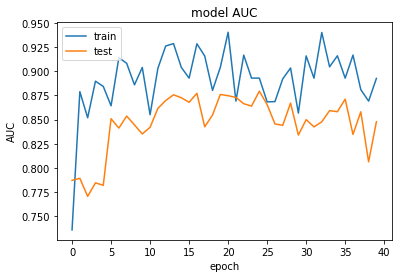

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

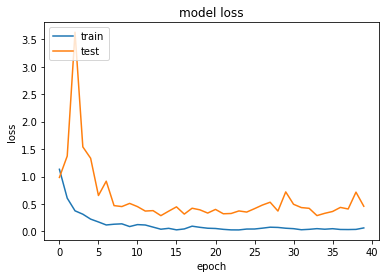

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model13', custom_objects={'auc':auc})

#### Confusion Matrix for Train Data

100%|██████████| 1365/1365 [06:02<00:00,  3.77it/s]


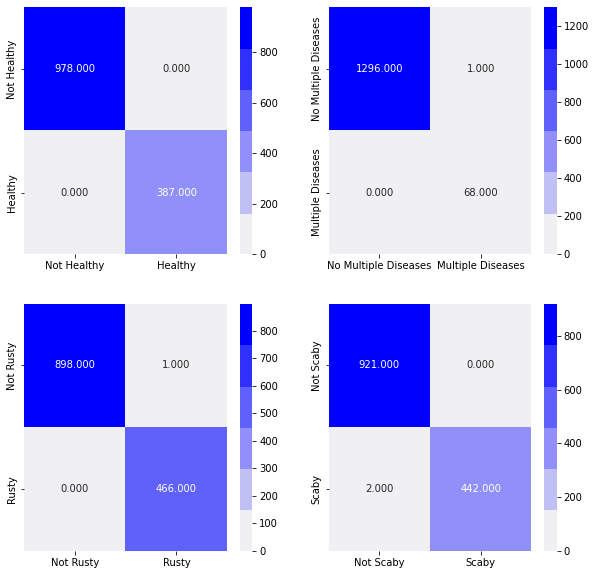

In [ ]:
confusion_matrix_(x_train, y_train)

#### Confusion Matrix for Test Data

100%|██████████| 456/456 [01:46<00:00,  4.27it/s]


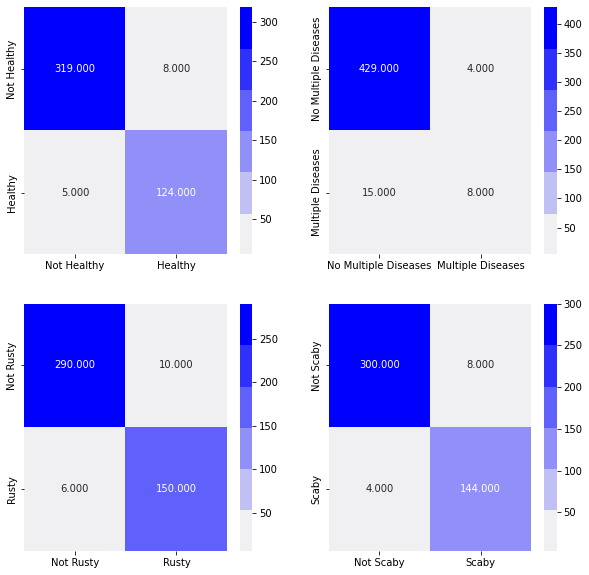

In [ ]:
confusion_matrix_(x_test, y_test)

# Kaggle Score for the above - 0.93115

## EfficientNetB4 Model, with Heavy Augmentation, along with Label Smoothing

In [ ]:
from efficientnet.tfkeras import EfficientNetB4

In [ ]:
def get_model():

  base_model = EfficientNetB4(include_top=False, weights='noisy-student',input_shape=(136, 204, 3),pooling='avg')

  droupout1 = Dropout(0.2)(base_model.layers[-1].output)

  dense7 = Dense(units = 16,activation="relu", kernel_regularizer = regularizers.L2(l2=0.01))(droupout1)#(base_model.layers[-1].output)#, kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4
         
  out_layer = Dense(4,activation='softmax')(dense7)
  
  model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),metrics=[auc],optimizer=tf.keras.optimizers.Adam())
  
  return  model



In [ ]:
model = get_model()

In [ ]:
ms = ModelSave() 

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=40, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/40
42/42 [==============================] - 174s 3s/step - loss: 1.4339 - auc: 0.6862 - val_loss: 1.4114 - val_auc: 0.7814
Epoch 2/40
42/42 [==============================] - 125s 3s/step - loss: 1.1371 - auc: 0.7724 - val_loss: 1.0421 - val_auc: 0.8002
Epoch 3/40
42/42 [==============================] - 132s 3s/step - loss: 1.0429 - auc: 0.7904 - val_loss: 0.9694 - val_auc: 0.8195
Epoch 4/40
42/42 [==============================] - 134s 3s/step - loss: 0.9729 - auc: 0.8175 - val_loss: 1.0975 - val_auc: 0.7830
Epoch 5/40
42/42 [==============================] - 123s 3s/step - loss: 0.9463 - auc: 0.8324 - val_loss: 0.9224 - val_auc: 0.8116
Epoch 6/40
42/42 [==============================] - 160s 4s/step - loss: 0.9197 - auc: 0.8191 - val_loss: 1.1571 - val_auc: 0.7687
Epoch 7/40
42/42 [==============================] - 253s 6s/step - loss: 0.8992 - auc: 0.8612 - val_loss: 0.8179 - val_auc: 0.8502
Epoch 8/40
42/42 [==============================] - 113s 3s/step - loss: 0.9108 - a

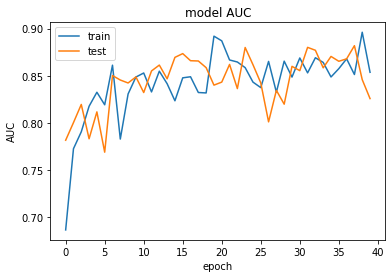

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

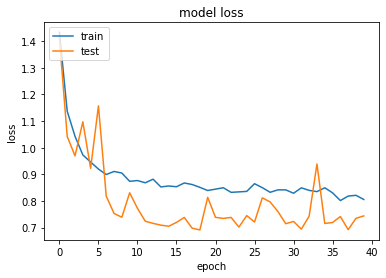

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model15', custom_objects={'auc':auc})

100%|██████████| 1365/1365 [04:24<00:00,  5.16it/s]


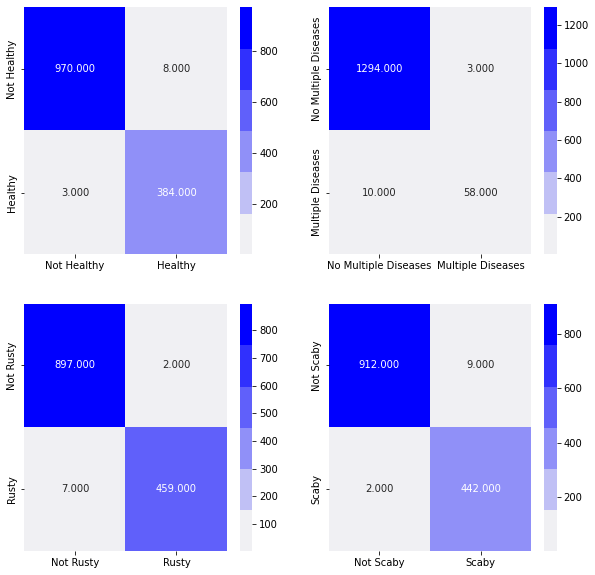

In [ ]:
confusion_matrix_(x_train, y_train)

100%|██████████| 456/456 [01:18<00:00,  5.79it/s]


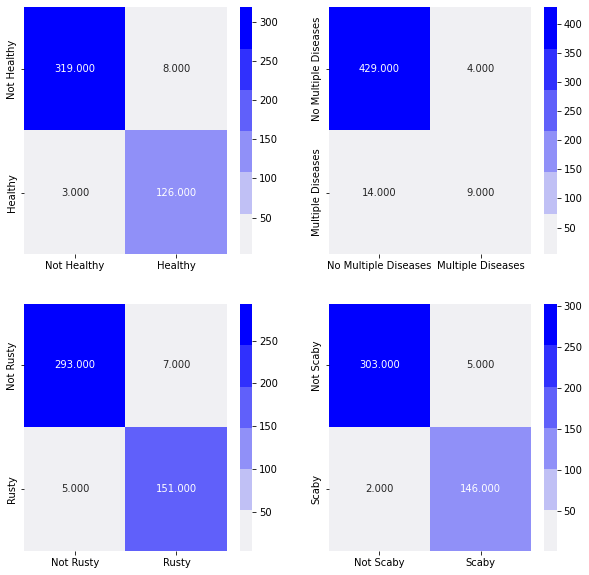

In [ ]:
confusion_matrix_(x_test, y_test)

# Kaggle Score for the above - 0.94532

### Ensemble of best models

In [ ]:
sub2 = pd.read_csv('sub47.csv')
sub3 = pd.read_csv('sub46.csv')
sub4 = pd.read_csv('sub45.csv')
a=1
b=0.2
c=0.4
sub = pd.read_csv('sample_submission.csv')
sub.healthy = sub2.healthy*a \
            + sub3.healthy*b \
            + sub4.healthy*c
sub.multiple_diseases = sub2.multiple_diseases * a \
                      + sub3.multiple_diseases * b \
                      + sub4.multiple_diseases * c
sub.scab = sub2.scab*a \
         + sub3.scab*b \
         + sub4.scab*c
sub.rust = sub2.rust*a \
         + sub3.rust*b \
         + sub4.rust*c
sub.to_csv('ensemble6.csv', index = None)  

## Ensemble of best models so far

In [ ]:
sub2 = pd.read_csv('sub32.csv')
sub3 = pd.read_csv('sub30.csv')
sub4 = pd.read_csv('sub25.csv')
a=0.9
b=0.6
c=0.4
sub = pd.read_csv('sample_submission.csv')
sub.healthy = sub2.healthy*a \
            + sub3.healthy*b \
            + sub4.healthy*c
sub.multiple_diseases = sub2.multiple_diseases * a \
                      + sub3.multiple_diseases * b \
                      + sub4.multiple_diseases * c
sub.scab = sub2.scab*a \
         + sub3.scab*b \
         + sub4.scab*c
sub.rust = sub2.rust*a \
         + sub3.rust*b \
         + sub4.rust*c
sub.to_csv('ensemble4_5.csv', index = None)  

## Kaggle Score - 0.94074

##  EfficientNetB6 with light Augmentations

In [ ]:
def get_model():

  base_model = EfficientNetB6(include_top=False, weights='noisy-student',input_shape=(204, 136, 3),pooling='avg')

  droupout1 = Dropout(0.2)(base_model.layers[-1].output)

  dense7 = Dense(units = 16,activation="relu", kernel_regularizer = regularizers.L2(l2=0.01))(droupout1)#(base_model.layers[-1].output)#, kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4
         
  out_layer = Dense(4,activation='softmax')(dense7)
  
  model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[auc],optimizer=tf.keras.optimizers.Adam())
  
  return  model




In [ ]:
model = get_model()

In [ ]:
ms = ModelSave() 

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=40, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/40
42/42 [==============================] - 63s 1s/step - loss: 1.4684 - auc: 0.6309 - val_loss: 1.6661 - val_auc: 0.6774
Epoch 2/40
42/42 [==============================] - 43s 1s/step - loss: 0.7999 - auc: 0.7930 - val_loss: 1.2212 - val_auc: 0.7623
Epoch 3/40
42/42 [==============================] - 43s 1s/step - loss: 0.6161 - auc: 0.8254 - val_loss: 2.1387 - val_auc: 0.6036
Epoch 4/40
42/42 [==============================] - 43s 1s/step - loss: 0.4392 - auc: 0.9016 - val_loss: 2.0992 - val_auc: 0.7257
Epoch 5/40
42/42 [==============================] - 43s 1s/step - loss: 0.4087 - auc: 0.8902 - val_loss: 1.4356 - val_auc: 0.7531
Epoch 6/40
42/42 [==============================] - 106s 3s/step - loss: 0.3239 - auc: 0.8504 - val_loss: 1.0657 - val_auc: 0.7943
Epoch 7/40
42/42 [==============================] - 45s 1s/step - loss: 0.2775 - auc: 0.8966 - val_loss: 1.4323 - val_auc: 0.7776
Epoch 8/40
42/42 [==============================] - 108s 3s/step - loss: 0.2371 - auc: 0.

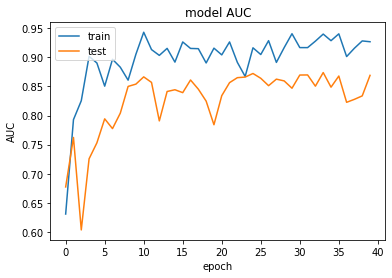

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

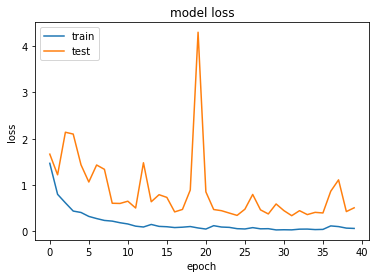

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model33', custom_objects={'auc':auc})

#### Confusion Matrix for Train Data

100%|██████████| 1365/1365 [04:40<00:00,  4.87it/s]


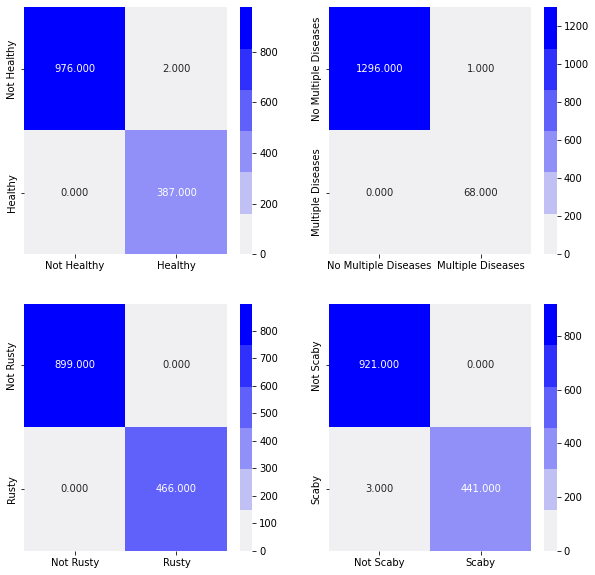

In [ ]:
confusion_matrix_(x_train, y_train)

#### Confusion Matrix for Test Data

100%|██████████| 456/456 [01:28<00:00,  5.17it/s]


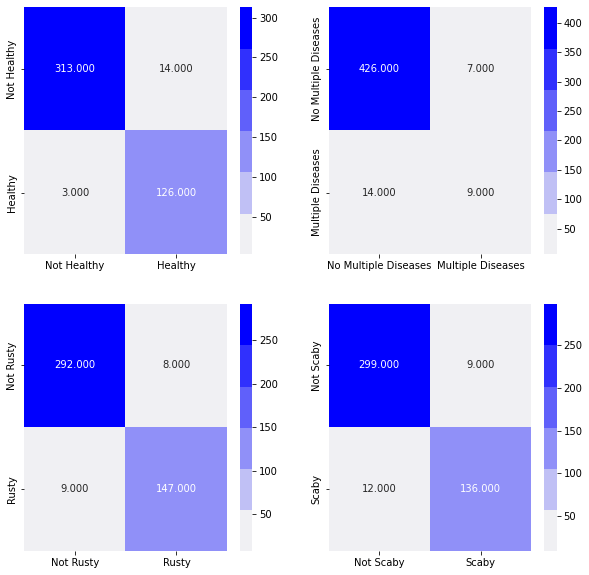

In [ ]:
confusion_matrix_(x_test, y_test)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'best_model24'
path = F"/content/gdrive/My Drive/{model_save_name}" 
best_model.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/best_model24/assets


# Kaggle Score for the above - 0.93501

##  EfficientNetB4 with light Augmentations

In [ ]:
def get_model():

  base_model = EfficientNetB4(include_top=False, weights='noisy-student',input_shape=(204, 136, 3),pooling='avg')
  #base_model.trainable = False

  #flattened = Flatten()(base_model.layers[-1].output)
    
  #droupout1 = Dropout(0)(flattened)
    
  #dense1 = Dense(units = 1024, activation="relu")(droupout1)
    
  #dense2 = Dense(units = 512, activation="relu")(dense1)
    
  #bn2 = BatchNormalization()(dense2)
    
  #dense3 = Dense(units = 256, activation="relu")(dense2)
    
  #dense4 = Dense(units = 128,activation="relu")(dense3)

  #dense5 = Dense(units = 128,activation="relu")(dense4)

  #dense6 = Dense(units = 64,activation="relu")(dense5)

  #dense7 = Dense(units = 16,activation="relu")(dense6)
  droupout1 = Dropout(0.2)(base_model.layers[-1].output)

  dense7 = Dense(units = 16,activation="relu", kernel_regularizer = regularizers.L2(l2=0.01))(droupout1)#(base_model.layers[-1].output)#, kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4
         
  out_layer = Dense(4,activation='softmax')(dense7)
  
  model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[auc],optimizer=tf.keras.optimizers.Adam())
  
  return  model




In [ ]:
model = get_model()

In [ ]:
ms = ModelSave()     # len(x_train)//32   len(x_test)//32

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=40, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/40
42/42 [==============================] - 77s 1s/step - loss: 1.1764 - auc: 0.7277 - val_loss: 1.0299 - val_auc: 0.7838
Epoch 2/40
42/42 [==============================] - 40s 936ms/step - loss: 0.5510 - auc: 0.8708 - val_loss: 0.7981 - val_auc: 0.8382
Epoch 3/40
42/42 [==============================] - 39s 915ms/step - loss: 0.3576 - auc: 0.8793 - val_loss: 0.8320 - val_auc: 0.8180
Epoch 4/40
42/42 [==============================] - 49s 1s/step - loss: 0.2879 - auc: 0.8816 - val_loss: 0.7084 - val_auc: 0.8111
Epoch 5/40
42/42 [==============================] - 39s 921ms/step - loss: 0.1709 - auc: 0.8996 - val_loss: 0.9012 - val_auc: 0.8281
Epoch 6/40
42/42 [==============================] - 39s 922ms/step - loss: 0.1836 - auc: 0.8531 - val_loss: 0.9341 - val_auc: 0.8020
Epoch 7/40
42/42 [==============================] - 40s 940ms/step - loss: 0.1211 - auc: 0.9387 - val_loss: 0.8595 - val_auc: 0.8154
Epoch 8/40
42/42 [==============================] - 39s 921ms/step - loss: 

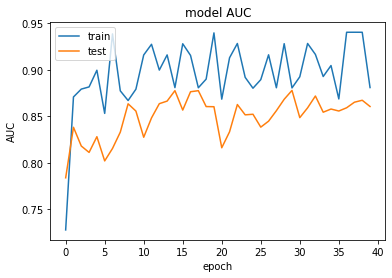

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

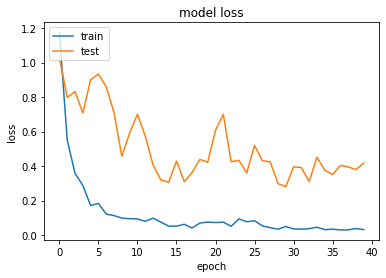

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model_0.8779_b4', custom_objects={'auc':auc})

#### Confusion Matrix for Train Data

100%|██████████| 1365/1365 [03:57<00:00,  5.74it/s]


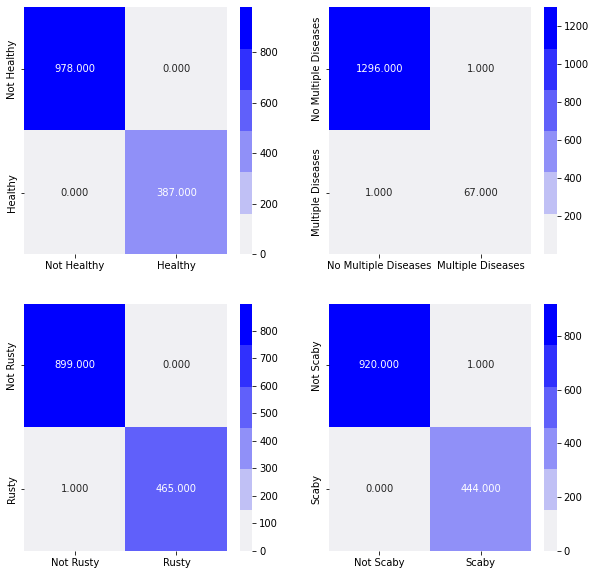

In [ ]:
confusion_matrix_(x_train, y_train)


#### Confusion Matrix for Test Data

100%|██████████| 456/456 [01:16<00:00,  5.95it/s]


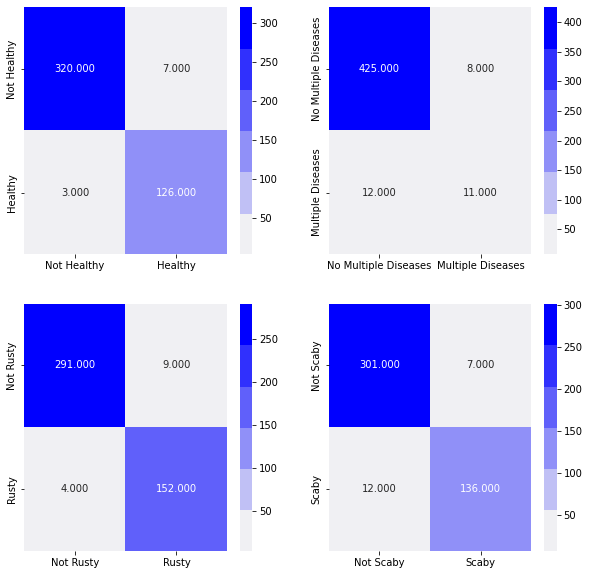

In [ ]:
confusion_matrix_(x_test, y_test)

# Kaggle Score for the above - 0.93309

## Ensemble of some the best Models

In [ ]:
sub2 = pd.read_csv('sub17.csv')
sub3 = pd.read_csv('sub18.csv')
sub4 = pd.read_csv('sub16.csv')
a=1
b=0.2
c=0.1
sub = pd.read_csv('sample_submission.csv')
sub.healthy = sub2.healthy*a \
            + sub3.healthy*b \
            + sub4.healthy*c
sub.multiple_diseases = sub2.multiple_diseases * a \
                      + sub3.multiple_diseases * b \
                      + sub4.multiple_diseases * c
sub.scab = sub2.scab*a \
         + sub3.scab*b \
         + sub4.scab*c
sub.rust = sub2.rust*a \
         + sub3.rust*b \
         + sub4.rust*c
sub.to_csv('ensemble3.csv', index = None)         

# Resnet50 Model

### Without Label Smoothing 

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

In [ ]:
def get_model():
  base_model = tf.keras.applications.ResNet50(include_top=False,weights=None, input_shape=(408, 274, 3))
  flattened = Flatten()(base_model.layers[-1].output)
    
  droupout1 = Dropout(0)(flattened)
    
  dense1 = Dense(units = 384, activation="relu")(droupout1)
    
  dense2 = Dense(units = 384, activation="relu")(dense1)
    
  bn2 = BatchNormalization()(dense2)
    
  dense3 = Dense(units = 480, activation="relu")(bn2)
    
  dense4 = Dense(units = 96,activation="relu")(dense3)
         
  out_layer = Dense(4,activation='softmax')(dense4)

  model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),metrics=[auc],optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

  return model



In [ ]:
model = get_model()

In [ ]:
ms = ModelSave()     # len(x_train)//32   len(x_test)//32

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=30, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/30
42/42 [==============================] - 109s 2s/step - loss: 1.3376 - auc: 0.5024 - val_loss: 1.2602 - val_auc: 0.5439
Epoch 2/30
42/42 [==============================] - 87s 2s/step - loss: 1.2810 - auc: 0.5391 - val_loss: 1.2500 - val_auc: 0.4895
Epoch 3/30
42/42 [==============================] - 84s 2s/step - loss: 1.2747 - auc: 0.5222 - val_loss: 1.2515 - val_auc: 0.5454
Epoch 4/30
42/42 [==============================] - 83s 2s/step - loss: 1.2420 - auc: 0.5562 - val_loss: 1.2638 - val_auc: 0.4989
Epoch 5/30
42/42 [==============================] - 83s 2s/step - loss: 1.2401 - auc: 0.5403 - val_loss: 1.3057 - val_auc: 0.5138
Epoch 6/30
42/42 [==============================] - 83s 2s/step - loss: 1.2374 - auc: 0.5538 - val_loss: 1.2808 - val_auc: 0.5050
Epoch 7/30
42/42 [==============================] - 83s 2s/step - loss: 1.2264 - auc: 0.5685 - val_loss: 1.3077 - val_auc: 0.5250
Epoch 8/30
42/42 [==============================] - 83s 2s/step - loss: 1.2373 - auc: 0.5

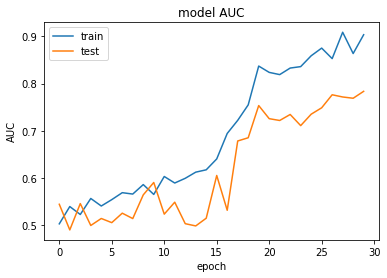

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

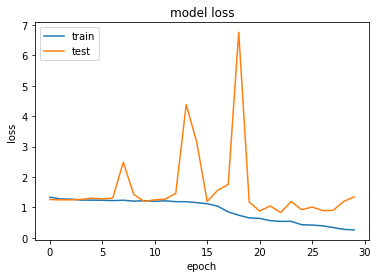

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model', custom_objects={'auc':auc})

100%|██████████| 456/456 [02:02<00:00,  3.73it/s]


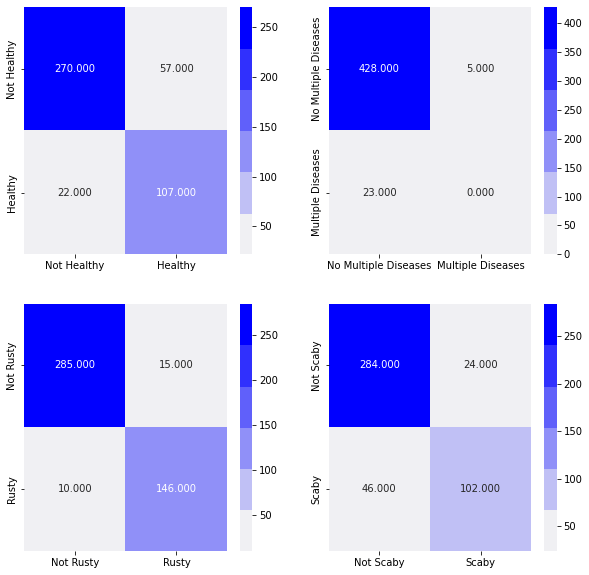

In [ ]:
confusion_matrix_(x_test, y_test)

100%|██████████| 1365/1365 [06:16<00:00,  3.63it/s]


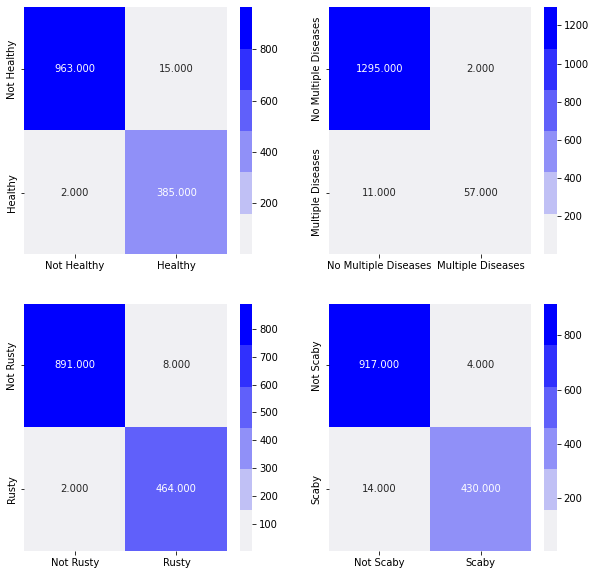

In [ ]:
confusion_matrix_(x_train, y_train)


# Kaggle Score for the above - 0.91309

In [ ]:
!zip -r ./model_zipped.zip ./best_model/

  adding: best_model/ (stored 0%)
  adding: best_model/assets/ (stored 0%)
  adding: best_model/saved_model.pb (deflated 92%)
  adding: best_model/keras_metadata.pb (deflated 95%)
  adding: best_model/variables/ (stored 0%)
  adding: best_model/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: best_model/variables/variables.index (deflated 81%)


In [ ]:
!pip install gdown==3.6.0

  Created wheel for gdown: filename=gdown-3.6.0-py3-none-any.whl size=5235 sha256=52549816373fc0b6e00de71aa224a09925ffbafb8fc2405426cdcd137b19421f
  Stored in directory: /root/.cache/pip/wheels/fa/16/df/0fd498965fab234700f8805ede80d6fd525a6fa306306a9f41
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


#### Saving the Model to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'resnet50'
path = F"/content/gdrive/My Drive/{model_save_name}" 
best_model.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/resnet50/assets


### With label smoothing = 0.2


In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()



In [ ]:
def get_model():
  base_model = tf.keras.applications.ResNet50(include_top=False,weights=None, input_shape=(408, 274, 3))
  flattened = Flatten()(base_model.layers[-1].output)
    
  droupout1 = Dropout(0)(flattened)
    
  dense1 = Dense(units = 384, activation="relu")(droupout1)
    
  dense2 = Dense(units = 384, activation="relu")(dense1)
    
  bn2 = BatchNormalization()(dense2)
    
  dense3 = Dense(units = 480, activation="relu")(bn2)
    
  dense4 = Dense(units = 96,activation="relu")(dense3)
         
  out_layer = Dense(4,activation='softmax')(dense4)

  model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),metrics=[auc],optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

  return model

In [ ]:
model = get_model()
ms = ModelSave()     # len(x_train)//32   len(x_test)//32

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=40, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/40
42/42 [==============================] - 57s 1s/step - loss: 1.3756 - auc: 0.5067 - val_loss: 1.3163 - val_auc: 0.5364
Epoch 2/40
42/42 [==============================] - 48s 1s/step - loss: 1.3322 - auc: 0.5450 - val_loss: 1.3022 - val_auc: 0.5272
Epoch 3/40
42/42 [==============================] - 48s 1s/step - loss: 1.3112 - auc: 0.5502 - val_loss: 1.5509 - val_auc: 0.4764
Epoch 4/40
42/42 [==============================] - 48s 1s/step - loss: 1.2891 - auc: 0.5841 - val_loss: 1.3240 - val_auc: 0.4711
Epoch 5/40
42/42 [==============================] - 48s 1s/step - loss: 1.2681 - auc: 0.6372 - val_loss: 1.3246 - val_auc: 0.5158
Epoch 6/40
42/42 [==============================] - 48s 1s/step - loss: 1.2412 - auc: 0.6379 - val_loss: 1.4405 - val_auc: 0.5155
Epoch 7/40
42/42 [==============================] - 48s 1s/step - loss: 1.1248 - auc: 0.7096 - val_loss: 1.3442 - val_auc: 0.5040
Epoch 8/40
42/42 [==============================] - 74s 2s/step - loss: 0.9748 - auc: 0.75

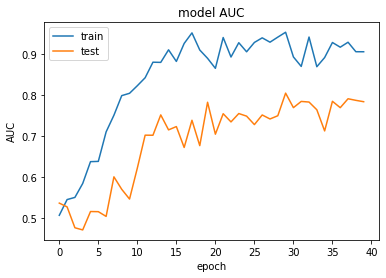

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

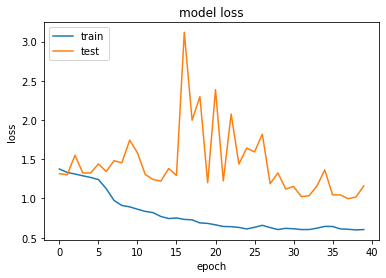

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model_resnet_0.7818', custom_objects={'auc':auc})

100%|██████████| 456/456 [01:08<00:00,  6.63it/s]


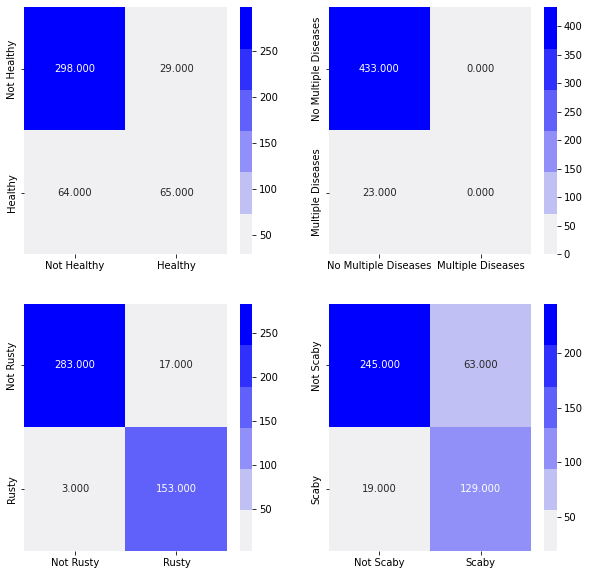

In [ ]:
confusion_matrix_(x_test, y_test)

# Kaggle Score for the above - 0.84758

#### With Label Smoothibng = 0.1

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

In [ ]:
def get_model():
  base_model = tf.keras.applications.ResNet50(include_top=False,weights=None, input_shape=(408, 274, 3))
  flattened = Flatten()(base_model.layers[-1].output)
    
  droupout1 = Dropout(0)(flattened)
    
  dense1 = Dense(units = 384, activation="relu")(droupout1)
    
  dense2 = Dense(units = 384, activation="relu")(dense1)
    
  bn2 = BatchNormalization()(dense2)
    
  dense3 = Dense(units = 480, activation="relu")(bn2)
    
  dense4 = Dense(units = 96,activation="relu")(dense3)
         
  out_layer = Dense(4,activation='softmax')(dense4)

  model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),metrics=[auc],optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

  return model

In [ ]:
model = get_model()
ms = ModelSave()     # len(x_train)//32   len(x_test)//32  

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=40, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/40
42/42 [==============================] - 59s 1s/step - loss: 1.3380 - auc: 0.5401 - val_loss: 1.2926 - val_auc: 0.5079
Epoch 2/40
42/42 [==============================] - 47s 1s/step - loss: 1.3007 - auc: 0.5688 - val_loss: 1.2925 - val_auc: 0.5486
Epoch 3/40
42/42 [==============================] - 47s 1s/step - loss: 1.2595 - auc: 0.6062 - val_loss: 1.3063 - val_auc: 0.5391
Epoch 4/40
42/42 [==============================] - 47s 1s/step - loss: 1.1542 - auc: 0.6823 - val_loss: 1.3243 - val_auc: 0.4873
Epoch 5/40
42/42 [==============================] - 47s 1s/step - loss: 0.9695 - auc: 0.7464 - val_loss: 1.3922 - val_auc: 0.5306
Epoch 6/40
42/42 [==============================] - 72s 2s/step - loss: 0.8466 - auc: 0.8100 - val_loss: 2.4805 - val_auc: 0.5496
Epoch 7/40
42/42 [==============================] - 47s 1s/step - loss: 0.7788 - auc: 0.7669 - val_loss: 1.9305 - val_auc: 0.5411
Epoch 8/40
42/42 [==============================] - 47s 1s/step - loss: 0.7610 - auc: 0.82

In [ ]:
best_model = keras.models.load_model('best_model', custom_objects={'auc':auc})

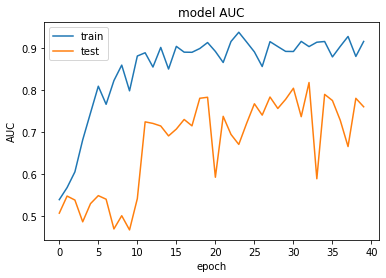

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

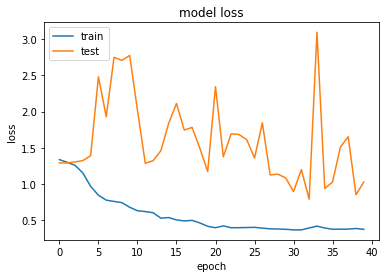

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

100%|██████████| 456/456 [01:19<00:00,  5.73it/s]


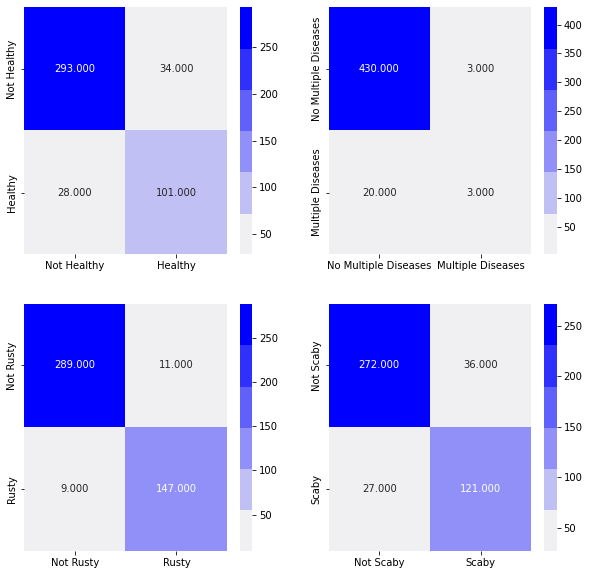

In [ ]:
confusion_matrix_(x_test, y_test)

# Kaggle Score for the above - 0.88043

# Building an Ensemble

In [ ]:
from tqdm import tqdm

In [ ]:
sub3 = pd.read_csv('sub3.csv')

In [ ]:
sub4 = pd.read_csv('sub11.csv')

In [ ]:
a=0.1
b=1
c=0.2

In [ ]:
sub = pd.read_csv('sample_submission.csv')

In [ ]:
sub.healthy = sub2.healthy*a \
            + sub3.healthy*b \
            + sub4.healthy*c

In [ ]:
sub.multiple_diseases = sub2.multiple_diseases * a \
                      + sub3.multiple_diseases * b \
                      + sub4.multiple_diseases * c

In [ ]:
sub.scab = sub2.scab*a \
         + sub3.scab*b \
         + sub4.scab*c

In [ ]:
sub.rust = sub2.rust*a \
         + sub3.rust*b \
         + sub4.rust*c

In [ ]:
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.001228,0.009571,1.288397,0.000805
1,Test_1,0.002597,0.051682,1.241653,0.004068
2,Test_2,0.007503,0.006854,0.001831,1.283812
3,Test_3,1.271756,0.007721,0.003388,0.017136
4,Test_4,0.000957,0.010753,1.287268,0.001021


In [ ]:
sub.to_csv('ensemble2.csv', index = None)

# Kaggle Score for the above - 0.91977

# DenseNet121 Model

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

In [ ]:
def get_model():
  base_model = tf.keras.applications.DenseNet121( include_top=False, weights=None, input_shape=(204, 136, 3))
  flattened = Flatten()(base_model.layers[-1].output)
    
  droupout1 = Dropout(0.3)(flattened)
    
  dense1 = Dense(units = 64, activation="relu")(droupout1)
    
  dense2 = Dense(units = 352, activation="relu")(dense1)
    
  bn2 = BatchNormalization()(dense2)
    
  dense3 = Dense(units = 256, activation="relu")(bn2)
    
  dense4 = Dense(units = 448,activation="relu")(dense3)
         
  out_layer = Dense(4,activation='softmax')(dense4)

  model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[auc],optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

  return model

In [ ]:
model = get_model()
ms = ModelSave() 

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=40, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/40
42/42 [==============================] - 59s 826ms/step - loss: 1.6349 - auc: 0.5023 - val_loss: 128293396480.0000 - val_auc: 0.5000
Epoch 2/40
42/42 [==============================] - 39s 929ms/step - loss: 1.2778 - auc: 0.5297 - val_loss: 86510.8516 - val_auc: 0.5000
Epoch 3/40
42/42 [==============================] - 37s 882ms/step - loss: 1.2532 - auc: 0.5667 - val_loss: 1007.7228 - val_auc: 0.4999
Epoch 4/40
42/42 [==============================] - 37s 892ms/step - loss: 1.2620 - auc: 0.5419 - val_loss: 4.8327 - val_auc: 0.5418
Epoch 5/40
42/42 [==============================] - 37s 878ms/step - loss: 1.2414 - auc: 0.5362 - val_loss: 1.2895 - val_auc: 0.5180
Epoch 6/40
42/42 [==============================] - 75s 2s/step - loss: 1.2186 - auc: 0.5835 - val_loss: 1.2331 - val_auc: 0.5518
Epoch 7/40
42/42 [==============================] - 78s 2s/step - loss: 1.1990 - auc: 0.5909 - val_loss: 1.3162 - val_auc: 0.5677
Epoch 8/40
42/42 [==============================] - 38s 9

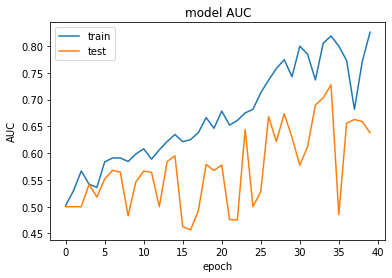

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

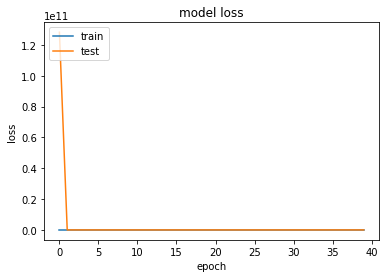

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Training the same for 40 more epochs

In [ ]:
history = model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=40, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks = [ms] )

Epoch 1/40
42/42 [==============================] - 49s 1s/step - loss: 0.5372 - auc: 0.7966 - val_loss: 1.3260 - val_auc: 0.7248
Epoch 2/40
42/42 [==============================] - 37s 885ms/step - loss: 0.5050 - auc: 0.8063 - val_loss: 1.6261 - val_auc: 0.7103
Epoch 3/40
42/42 [==============================] - 39s 938ms/step - loss: 0.4906 - auc: 0.8399 - val_loss: 1.6026 - val_auc: 0.6598
Epoch 4/40
42/42 [==============================] - 38s 896ms/step - loss: 0.5001 - auc: 0.8034 - val_loss: 1.3338 - val_auc: 0.6534
Epoch 5/40
42/42 [==============================] - 38s 898ms/step - loss: 0.4257 - auc: 0.8282 - val_loss: 0.7037 - val_auc: 0.7781
Epoch 6/40
42/42 [==============================] - 38s 893ms/step - loss: 0.4358 - auc: 0.8256 - val_loss: 0.9378 - val_auc: 0.7781
Epoch 7/40
42/42 [==============================] - 38s 909ms/step - loss: 0.4372 - auc: 0.8057 - val_loss: 42.0769 - val_auc: 0.6009
Epoch 8/40
42/42 [==============================] - 39s 917ms/step - lo

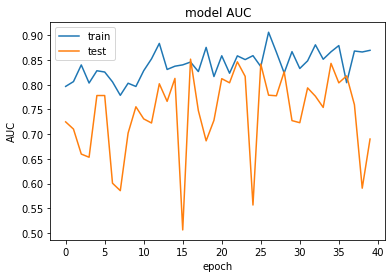

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

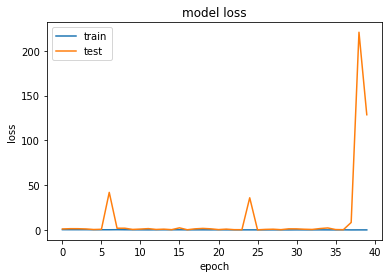

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Kaggle Score for the above - 0.88644

## Baseline Model

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

In [ ]:
input_layer = Input([156, 256, 3])
conv_1 = Conv2D(filters = 16, kernel_size = (3,3))(input_layer)
flattened = Flatten()(conv_1)
out_layer = Dense(units=4, activation = 'softmax')(flattened)

In [ ]:
model = Model(inputs = input_layer, outputs = out_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 156, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 154, 254, 16)      448       
_________________________________________________________________
flatten (Flatten)            (None, 625856)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2503428   
Total params: 2,503,876
Trainable params: 2,503,876
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=[auc])

In [ ]:
model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=10, validation_data=test_image_generator, validation_steps=len(x_test)//32 )

Epoch 1/10
42/42 [==============================] - 35s 805ms/step - loss: 13.5081 - auc: 0.5234 - val_loss: 2.3487 - val_auc: 0.5528
Epoch 2/10
42/42 [==============================] - 34s 817ms/step - loss: 1.6316 - auc: 0.7295 - val_loss: 2.0563 - val_auc: 0.5498
Epoch 3/10
42/42 [==============================] - 35s 849ms/step - loss: 0.6897 - auc: 0.8344 - val_loss: 1.7666 - val_auc: 0.5811
Epoch 4/10
42/42 [==============================] - 35s 840ms/step - loss: 0.4079 - auc: 0.8345 - val_loss: 1.6214 - val_auc: 0.5488
Epoch 5/10
42/42 [==============================] - 35s 845ms/step - loss: 0.2334 - auc: 0.8992 - val_loss: 1.5801 - val_auc: 0.5589
Epoch 6/10
42/42 [==============================] - 35s 842ms/step - loss: 0.1745 - auc: 0.9243 - val_loss: 1.5873 - val_auc: 0.5672
Epoch 7/10
42/42 [==============================] - 35s 848ms/step - loss: 0.1181 - auc: 0.9497 - val_loss: 1.6255 - val_auc: 0.5480
Epoch 8/10
42/42 [==============================] - 39s 941ms/step -

# Kaggle Score - 0.56159

### Resnet50 Model, model.trainable = False

In [ ]:
base_model = tf.keras.applications.ResNet50(include_top=False,weights="imagenet", input_shape=(156, 256, 3))
base_model.trainable = False

In [ ]:
conv_1 = Conv2D(filters = 16, kernel_size = (3,3))(base_model.layers[-1].output)
flattened = Flatten()(conv_1)
out_layer = Dense(units=4, activation = 'softmax')(flattened)

In [ ]:
model = Model(inputs = base_model.layers[0].input, outputs = out_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 156, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 162, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 78, 128, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 78, 128, 64)  256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=[auc])

In [ ]:
model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=10, validation_data=test_image_generator, validation_steps=len(x_test)//32 )

Epoch 1/10
42/42 [==============================] - 75s 2s/step - loss: 2.5800 - auc: 0.5565 - val_loss: 1.5497 - val_auc: 0.6014
Epoch 2/10
42/42 [==============================] - 66s 2s/step - loss: 1.3340 - auc: 0.6410 - val_loss: 1.2149 - val_auc: 0.6374
Epoch 3/10
42/42 [==============================] - 66s 2s/step - loss: 1.2136 - auc: 0.6905 - val_loss: 1.2866 - val_auc: 0.6471
Epoch 4/10
42/42 [==============================] - 66s 2s/step - loss: 1.1526 - auc: 0.7015 - val_loss: 1.2320 - val_auc: 0.6557
Epoch 5/10
42/42 [==============================] - 66s 2s/step - loss: 1.1238 - auc: 0.7177 - val_loss: 1.1655 - val_auc: 0.6602
Epoch 6/10
42/42 [==============================] - 66s 2s/step - loss: 1.0778 - auc: 0.7259 - val_loss: 1.1733 - val_auc: 0.6534
Epoch 7/10
42/42 [==============================] - 66s 2s/step - loss: 1.0903 - auc: 0.7327 - val_loss: 1.1704 - val_auc: 0.6595
Epoch 8/10
42/42 [==============================] - 66s 2s/step - loss: 1.0224 - auc: 0.75

# Kaggle Score 0.63478

## Creating Sample Submission File

In [ ]:
df_test = pd.read_csv('test.csv')

In [ ]:
##Getting image directories
list_of_test_data = []
for i in df_test.image_id:
    list_of_test_data.append(os.path.join(dir_path,i+".jpg"))

In [ ]:
##Getting image names
test_data = []
for i in df_test.image_id:
    test_data.append(i)

In [ ]:
a = np.empty((0,4),float)
for i in tqdm(list_of_test_data):
    image_string = tf.io.read_file(i)
    #decoding image
    image = tf.image.decode_jpeg(image_string, channels=3)
    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    #resize the image
    image = tf.image.resize(image, [136, 204])
    #print(image.shape)
    image = tf.expand_dims(image, axis=0)
    a = np.concatenate((a,best_model.predict(image)), axis=0)

    

100%|██████████| 1821/1821 [02:54<00:00, 10.43it/s]


In [ ]:
b = pd.DataFrame(a)
b['image_id'] = test_data
b.columns= ['healthy', 'multiple_diseases', 'rust', 'scab', 'image_id'] # Naming the columns
b = b[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']] # Reodering the column
b.set_index('image_id')

,healthy,multiple_diseases,rust,scab
image_id,,,,
Test_0,0.065918,0.060972,0.810887,0.062224
Test_1,0.058584,0.058306,0.818371,0.064738
Test_2,0.032185,0.017392,0.024910,0.925513
Test_3,0.939021,0.023173,0.018728,0.019078
Test_4,0.075736,0.063383,0.790808,0.070072
...,...,...,...,...
Test_1816,0.058799,0.067504,0.801570,0.072127
Test_1817,0.169581,0.405995,0.071032,0.353392
Test_1818,0.057855,0.087979,0.780018,0.074148


In [ ]:
b.to_csv('sub48.csv', index = None)